# Importing libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import logging
from datetime import datetime

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, log_loss, make_scorer, confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode

# Utils

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# def imshow(inp, title=None):
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
def visualize_model(model, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, phase_names, device, log):
  try:
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}/{num_epochs}')
      print('-' * 10)
      if log is not None:
        log.info(f'Epoch {epoch + 1}/{num_epochs}')

      # Each epoch has a training and validation phase
      for phase in phase_names:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        # running_f1

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          # running_f1 = f1_score(labels.data, preds)
        if phase == 'train':
          scheduler.step()
          
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        # epoch_f1_score = f1_score()
        # epoch_f1 = running_f1.double() / dataset_sizes[phase]

        print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')
        if log is not None:
          log.info(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    if log is not None:
      log.info(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      log.info(f'Best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  except KeyboardInterrupt:
    print('Function interrupted')
    if log is not None:
      log.info('Function interrupted\n\n\n')
    return None

In [16]:
def train_model_without_scheduler(model, criterion, optimizer, num_epochs, dataloaders, phase_names, device, log):
  try:
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}/{num_epochs}')
      print('-' * 10)
      if log is not None:
        log.info(f'Epoch {epoch + 1}/{num_epochs}')

      # Each epoch has a training and validation phase
      for phase in phase_names:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        # running_f1

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          # running_f1 = f1_score(labels.data, preds)
          
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        # epoch_f1_score = f1_score()
        # epoch_f1 = running_f1.double() / dataset_sizes[phase]

        print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')
        if log is not None:
          log.info(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    if log is not None:
      log.info(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      log.info(f'Best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  except KeyboardInterrupt:
    print('Function interrupted')
    if log is not None:
      log.info('Function interrupted\n\n\n')
    return None

In [17]:
def define_dataloaders(dataset_name, interpolation, batch_size=32, val=False):
  data_dir = '/content'
  train = dataset_name + '_train'
  test = dataset_name + '_test'
  phase_names = ['train', 'test']
  phase_folders = [train, test]
  if val:
    VAL = dataset_name + '_val'
    phase_names.append('val')
    phase_folders.append(VAL)

  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize(224, interpolation=interpolation),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
      ),
      'test': transforms.Compose([
          transforms.Resize(224, interpolation=interpolation),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
      ),
  }

  image_datasets = {pn: datasets.ImageFolder(os.path.join(data_dir, pf),
                                            data_transforms[pn])
                    for pn, pf in zip(phase_names, phase_folders)}
  dataloaders = {pn: torch.utils.data.DataLoader(image_datasets[pn], 
                                                batch_size=batch_size,
                                                shuffle=True, num_workers=0) 
                for pn in phase_names}
  dataset_sizes = {pn: len(image_datasets[pn]) for pn in phase_names}
  class_names = image_datasets['train'].classes

  for pn in phase_names:
      print("Loaded {} images under {}".format(dataset_sizes[pn], pn))
      
  class_names = image_datasets['train'].classes
  print('Classes: %s' % image_datasets['train'].classes)
  return dataloaders, dataset_sizes, class_names

In [18]:
def define_dataloaders_custom(dataset_name, interpolation, batch_size=32, val=False, s=224):
  data_dir = '/content'
  train = dataset_name + '_train'
  test = dataset_name + '_test'
  phase_names = ['train', 'test']
  phase_folders = [train, test]
  if val:
    VAL = dataset_name + '_val'
    phase_names.append('val')
    phase_folders.append(VAL)

  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize((s, s), interpolation=interpolation),
          transforms.ToTensor(),
          # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
      ),
      'test': transforms.Compose([
          transforms.Resize((s, s), interpolation=interpolation),
          transforms.ToTensor(),
          # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
      ),
  }

  image_datasets = {pn: datasets.ImageFolder(os.path.join(data_dir, pf),
                                            data_transforms[pn])
                    for pn, pf in zip(phase_names, phase_folders)}
  dataloaders = {pn: torch.utils.data.DataLoader(image_datasets[pn], 
                                                batch_size=batch_size,
                                                shuffle=True, num_workers=0,
                                                pin_memory=True) 
                for pn in phase_names}
  dataset_sizes = {pn: len(image_datasets[pn]) for pn in phase_names}
  class_names = image_datasets['train'].classes

  for pn in phase_names:
      print("Loaded {} images under {}".format(dataset_sizes[pn], pn))
      
  class_names = image_datasets['train'].classes
  print('Classes: %s' % image_datasets['train'].classes)
  return dataloaders, dataset_sizes, class_names

In [19]:
def check_gpu(log=None):
  if torch.cuda.is_available():
    print('GPU is available. Running on GPU')
    # if log is not None:
    #   log.info('GPU is available. Running on GPU')
    device = "cuda:0"
  else:
    print('GPU is NOT available. Running on CPU')
    # if log is not None:
    #   log.info('GPU is NOT available. Running on CPU')
    device = "cpu"
  return device

In [20]:
def plot_confusion_matrix(test_y, predictions):
  if type(test_y) == list:
    test_y = pd.Series(test_y)
  labels = np.sort(np.array(test_y.unique(), dtype = 'str'))
  mat = confusion_matrix(test_y, predictions)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

In [21]:
def show_report(test_y, predictions, log=None):
  print('Metrics values:')
  print('Test accuracy: %s' % round(accuracy_score(test_y, predictions), 4))
  print('Test balanced_accuracy', round(balanced_accuracy_score(test_y, predictions), 4))
  print('Test f1_score: %s' % round(f1_score(test_y, predictions, average='macro'), 4))
  print('Classification report')
  print(classification_report(test_y, predictions))
  print()

  plot_confusion_matrix(test_y, predictions)

  if log is not None:
    log.info('Metrics values:')
    log.info('Test accuracy: %s' % round(accuracy_score(test_y, predictions), 4))
    log.info('Test balanced_accuracy', round(balanced_accuracy_score(test_y, predictions), 4))
    log.info('Test f1_score: %s' % round(f1_score(test_y, predictions, average='macro'), 4))
    log.info('Classification report')
    log.info(classification_report(test_y, predictions))

# Connect to Google Drive (if needed)

In [10]:
# Подключить к google colab содержимое вашего google диск
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Define logs

In [11]:
def define_logs(logs_folder, logs_filename):
  if not os.path.isdir(logs_folder):
    os.mkdir(logs_folder)
  logs_path = os.path.join(logs_folder, logs_filename)
  log_formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
  logger = logging.getLogger('experimental_classification')
  logger.setLevel(logging.DEBUG)
  file_handler = logging.FileHandler(logs_path)
  file_handler.setLevel(logging.DEBUG)
  file_handler.setFormatter(log_formatter)
  logger.addHandler(file_handler)
  print('Logger was initialized successfully')
  return logger

In [12]:
logs_folder = "/content/drive/MyDrive/Master/MW_Semenov_6381/logs"
logs_filename = "SWaT_Dec2019_classify_each_packet.log"
logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)

Logger was initialized successfully


# Sergey Golubev images

## First run

### Downloading data

In [ ]:
%%time
!unzip "/content/drive/MyDrive/Master/MW/datasets/SWaT img/100k dataset img.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: img/Normal/34x34/Image #68500-116.png  
 extracting: img/Normal/34x34/Image #68501-120.png  
 extracting: img/Normal/34x34/Image #68502-140.png  
 extracting: img/Normal/34x34/Image #68503-116.png  
 extracting: img/Normal/34x34/Image #68504-116.png  
 extracting: img/Normal/34x34/Image #68505-60.png  
 extracting: img/Normal/34x34/Image #68506-64.png  
 extracting: img/Normal/34x34/Image #68507-116.png  
 extracting: img/Normal/34x34/Image #68508-66.png  
 extracting: img/Normal/34x34/Image #68509-60.png  
 extracting: img/Normal/34x34/Image #6851-60.png  
 extracting: img/Normal/34x34/Image #68510-60.png  
 extracting: img/Normal/34x34/Image #68511-64.png  
 extracting: img/Normal/34x34/Image #68512-86.png  
 extracting: img/Normal/34x34/Image #68513-90.png  
 extracting: img/Normal/34x34/Image #68514-66.png  
 extracting: img/Normal/34x34/Image #68515-66.png  
 extracting: img/Normal/34x34/Image #68516-

### Prepare data

In [ ]:
train_path = '/content/golubev_SWaT_images_train'
train_normal_path = os.path.join(train_path, 'normal')
train_attack_path = os.path.join(train_path, 'attack')
test_path = '/content/golubev_SWaT_images_test'
test_normal_path = os.path.join(test_path, 'normal')
test_attack_path = os.path.join(test_path, 'attack')

os.mkdir(train_path)
os.mkdir(train_normal_path)
os.mkdir(train_attack_path)
os.mkdir(test_path)
os.mkdir(test_normal_path)
os.mkdir(test_attack_path)

In [ ]:
normal_path = '/content/img/Normal/34x34'
attack_path = '/content/img/Attack/34x34'

In [ ]:
i = 0
for normal_img in os.listdir(normal_path):
  if i < 7:
    os.rename(os.path.join(normal_path, normal_img), os.path.join(train_normal_path, normal_img))
  elif i < 10:
    os.rename(os.path.join(normal_path, normal_img), os.path.join(test_normal_path, normal_img))
  else:
    i = 0
    os.rename(os.path.join(normal_path, normal_img), os.path.join(train_normal_path, normal_img))
  i += 1

In [ ]:
i = 0
for attack_img in os.listdir(attack_path):
  if i < 7:
    os.rename(os.path.join(attack_path, attack_img), os.path.join(train_attack_path, attack_img))
  elif i < 10:
    os.rename(os.path.join(attack_path, attack_img), os.path.join(test_attack_path, attack_img))
  else:
    i = 0
    os.rename(os.path.join(attack_path, attack_img), os.path.join(train_attack_path, attack_img))
  i += 1

In [ ]:
# !rm -rf '/content/golubev_SWaT_images_train'
# !rm -rf '/content/golubev_SWaT_images_test'
# ! rm -rf '/content/img'

In [ ]:
!tar -czvf "golubev_SWaT_images_train.tar.gz" -C "/content" "golubev_SWaT_images_train" 
!cp "/content/golubev_SWaT_images_train.tar.gz" "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images"

!tar -czvf "golubev_SWaT_images_test.tar.gz" -C "/content" "golubev_SWaT_images_test" 
!cp "/content/golubev_SWaT_images_test.tar.gz" "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images"

Выходные данные были обрезаны до нескольких последних строк (5000).
golubev_SWaT_images_test/normal/Image #48252-116.png
golubev_SWaT_images_test/normal/Image #69077-64.png
golubev_SWaT_images_test/normal/Image #23687-124.png
golubev_SWaT_images_test/normal/Image #28738-148.png
golubev_SWaT_images_test/normal/Image #5024-60.png
golubev_SWaT_images_test/normal/Image #25997-130.png
golubev_SWaT_images_test/normal/Image #62673-60.png
golubev_SWaT_images_test/normal/Image #64290-90.png
golubev_SWaT_images_test/normal/Image #32932-64.png
golubev_SWaT_images_test/normal/Image #59264-86.png
golubev_SWaT_images_test/normal/Image #61096-104.png
golubev_SWaT_images_test/normal/Image #20073-64.png
golubev_SWaT_images_test/normal/Image #38843-98.png
golubev_SWaT_images_test/normal/Image #47113-112.png
golubev_SWaT_images_test/normal/Image #56569-86.png
golubev_SWaT_images_test/normal/Image #27644-64.png
golubev_SWaT_images_test/normal/Image #50607-60.png
golubev_SWaT_images_test/normal/Image #4122

## Download data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/golubev_SWaT_images_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/golubev_SWaT_images_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
golubev_SWaT_images_test/normal/Image #23687-124.png
golubev_SWaT_images_test/normal/Image #28738-148.png
golubev_SWaT_images_test/normal/Image #5024-60.png
golubev_SWaT_images_test/normal/Image #25997-130.png
golubev_SWaT_images_test/normal/Image #62673-60.png
golubev_SWaT_images_test/normal/Image #64290-90.png
golubev_SWaT_images_test/normal/Image #32932-64.png
golubev_SWaT_images_test/normal/Image #59264-86.png
golubev_SWaT_images_test/normal/Image #61096-104.png
golubev_SWaT_images_test/normal/Image #20073-64.png
golubev_SWaT_images_test/normal/Image #38843-98.png
golubev_SWaT_images_test/normal/Image #47113-112.png
golubev_SWaT_images_test/normal/Image #56569-86.png
golubev_SWaT_images_test/normal/Image #27644-64.png
golubev_SWaT_images_test/normal/Image #50607-60.png
golubev_SWaT_images_test/normal/Image #41229-120.png
golubev_SWaT_images_test/normal/Image #11968-64.png
golubev_SWaT_images_test/normal/Image #9758

## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'golubev_SWaT_images'
LEARNING_RATE = 0.001
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 20
BATCH_SIZE = 64
VALIDATION = False
INTERPOLATION = transforms.InterpolationMode.NEAREST

dataloaders, dataset_sizes, class_names = define_dataloaders_custom(dataset_name=dataset_name, interpolation=INTERPOLATION, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 70000 images under train
Loaded 30000 images under test
Classes: ['attack', 'normal']


torch.Size([64, 3, 224, 224])


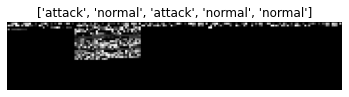

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

Device: cpu
Data: golubev_SWaT_images, batch size: 64
ResNet34 model parameters: LR: 0.01, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 0.7167 acc: 0.6557
test loss: 0.5895 acc: 0.7033

Epoch 2/7
----------


### Multiple head layers

In [ ]:
model_resnet34_head = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34_head.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34_head.fc.in_features
head_model = nn.Sequential(
	nn.Linear(num_features_resnet34, 512),
	nn.ReLU(),
	nn.Dropout(0.1),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Dropout(0.05),
	nn.Linear(256, len(class_names))
)
model_resnet34_head.fc = head_model
model_resnet34_head.name = 'ResNet34withHead'
model_resnet34_head = model_resnet34_head.to(device)

criterion_resnet34_head = nn.CrossEntropyLoss()
optimizer_resnet34_head = optim.SGD(model_resnet34_head.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34_head = lr_scheduler.StepLR(optimizer_resnet34_head, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34_head.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34_head.name)
model_resnet34_head = train_model(model=model_resnet34_head, 
                                  criterion=criterion_resnet34_head, 
                                  optimizer=optimizer_resnet34_head,
                                  scheduler=exp_lr_scheduler_resnet34_head, 
                                  num_epochs=EPOCHS_COUNT, 
                                  dataloaders=dataloaders, 
                                  phase_names=phase_names,
                                  device=device,
                                  log=logger)
if model_resnet34_head is not None: 
  print('Train %s model end' % model_resnet34_head.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34_head.name)

## MobileNet_v3_small

### One head layer

In [ ]:
model_mobilenetv3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
for param in model_mobilenetv3_small.parameters():
    param.requires_grad = False
num_features_mobilenetv3_small = model_mobilenetv3_small.classifier[-1].in_features
model_mobilenetv3_small.classifier[-1] = nn.Linear(num_features_mobilenetv3_small, len(class_names))
model_mobilenetv3_small.name = 'MobileNet_v3_small'
model_mobilenetv3_small = model_mobilenetv3_small.to(device)

criterion_mobilenetv3_small = nn.CrossEntropyLoss()
optimizer_mobilenetv3_small = optim.SGD(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_mobilenetv3_small= lr_scheduler.StepLR(optimizer_mobilenetv3_small, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_mobilenetv3_small.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_mobilenetv3_small.name)
model_mobilenetv3_small = train_model(model=model_mobilenetv3_small, 
                                      criterion=criterion_mobilenetv3_small, 
                                      optimizer=optimizer_mobilenetv3_small,
                                      scheduler=exp_lr_scheduler_mobilenetv3_small, 
                                      num_epochs=EPOCHS_COUNT, 
                                      dataloaders=dataloaders, 
                                      phase_names=phase_names,
                                      device=device,
                                      log=logger)
if model_mobilenetv3_small is not None: 
  print('Train %s model end' % model_mobilenetv3_small.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_mobilenetv3_small.name)

Device: cuda:0
Data: golubev_SWaT_images, batch size: 64
MobileNet_v3_small model parameters: LR: 0.01, SS: 2, G: 0.1, EC: 7
Train MobileNet_v3_small model start ...
Epoch 1/7
----------
train loss: 0.5930 acc: 0.6978
test loss: 0.6594 acc: 0.6995

Epoch 2/7
----------
train loss: 0.5854 acc: 0.7025
test loss: 0.5636 acc: 0.7276

Epoch 3/7
----------
train loss: 0.5708 acc: 0.7133
test loss: 0.5470 acc: 0.7264

Epoch 4/7
----------
train loss: 0.5697 acc: 0.7119
test loss: 0.5470 acc: 0.7320

Epoch 5/7
----------
train loss: 0.5674 acc: 0.7162
test loss: 0.5473 acc: 0.7323

Epoch 6/7
----------
train loss: 0.5674 acc: 0.7134
test loss: 0.5468 acc: 0.7320

Epoch 7/7
----------
train loss: 0.5679 acc: 0.7137
test loss: 0.5467 acc: 0.7323

Training complete in 21m 40s
Best val acc: 0.732333
Train MobileNet_v3_small model end
CPU times: user 6min 54s, sys: 2min 8s, total: 9min 2s
Wall time: 21min 41s


In [ ]:
%%time
predictions = list()
true_labels = list()

model_mobilenetv3_small.eval()

for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_mobilenetv3_small(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

# show_report(true_labels, predictions)

Metrics values:
Test accuracy: 0.6823
Test balanced_accuracy 0.5012
Test f1_score: 0.4459
Classification report
              precision    recall  f1-score   support

           0       0.31      0.05      0.08      9000
           1       0.70      0.95      0.81     21000

    accuracy                           0.68     30000
   macro avg       0.51      0.50      0.45     30000
weighted avg       0.58      0.68      0.59     30000




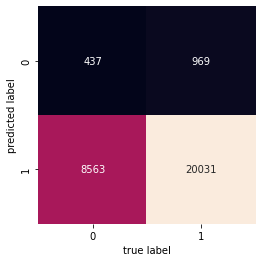

In [ ]:
show_report(true_labels, predictions[:30000])

## Custom CNN

### Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  print('{} - Start fit ...'.format(datetime.now()))
  for epoch in range(epochs):  
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  print('{} - End fit'.format(datetime.now()))
  return history

In [ ]:
class ImageClassificationBase(nn.Module):
    
  def training_step(self, batch):
    images, labels = batch[0].to(device), batch[1].to(device)
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  
  def validation_step(self, batch):
    images, labels = batch[0].to(device), batch[1].to(device)
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("{} - Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        datetime.now(), epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class AttackClassificator(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

### Run

In [ ]:
model = AttackClassificator()

In [ ]:
model.to(device)

AttackClassificator(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, dataloaders['train'], dataloaders['test'], opt_func)

2022-05-25 11:43:05.298704 - Start fit ...
2022-05-25 11:48:56.784398 - Epoch [0], train_loss: 0.6141, val_loss: 0.6132, val_acc: 0.7000


KeyboardInterrupt: ignored

# Linear transformation

## Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_linear_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_linear_transformation_test.tar.gz"

tar (child): /content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_linear_transformation_train.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): /content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_linear_transformation_test.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
CPU times: user 11.4 ms, sys: 14.1 ms, total: 25.6 ms
Wall time: 276 ms


## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_linear_transformation'
LEARNING_RATE = 0.001
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 8
VALIDATION = False
INTERPOLATION = 

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU


TypeError: ignored

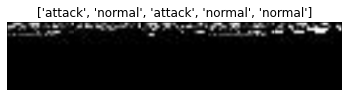

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

  predictions = list()
  true_labels = list()

  model_mobilenetv3_small.eval()

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_linear_transformation, batch size: 8
ResNet34 model parameters: LR: 0.001, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 0.7627 acc: 0.5519
test loss: 1.0999 acc: 0.4037

Epoch 2/7
----------
train loss: 0.7567 acc: 0.5565
test loss: 0.7587 acc: 0.5037

Epoch 3/7
----------
train loss: 0.6719 acc: 0.5954
test loss: 0.6685 acc: 0.5859

Epoch 4/7
----------
train loss: 0.6699 acc: 0.5945
test loss: 0.6625 acc: 0.6042

Epoch 5/7
----------
train loss: 0.6625 acc: 0.6030
test loss: 0.6605 acc: 0.6047

Epoch 6/7
----------
train loss: 0.6618 acc: 0.6033
test loss: 0.6609 acc: 0.6059

Epoch 7/7
----------
train loss: 0.6608 acc: 0.6061
test loss: 0.6615 acc: 0.6037

Training complete in 76m 40s
Best val acc: 0.605933
Train ResNet34 model end
CPU times: user 1h 12min 17s, sys: 3min 5s, total: 1h 15min 23s
Wall time: 1h 16min 40s


### Multiple head layers

In [ ]:
model_resnet34_head = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34_head.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34_head.fc.in_features
head_model = nn.Sequential(
	nn.Linear(num_features_resnet34, 512),
	nn.ReLU(),
	nn.Dropout(0.1),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Dropout(0.05),
	nn.Linear(256, len(class_names))
)
model_resnet34_head.fc = head_model
model_resnet34_head.name = 'ResNet34withHead'
model_resnet34_head = model_resnet34_head.to(device)

criterion_resnet34_head = nn.CrossEntropyLoss()
optimizer_resnet34_head = optim.SGD(model_resnet34_head.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34_head = lr_scheduler.StepLR(optimizer_resnet34_head, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34_head.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34_head.name)
model_resnet34_head = train_model(model=model_resnet34_head, 
                                  criterion=criterion_resnet34_head, 
                                  optimizer=optimizer_resnet34_head,
                                  scheduler=exp_lr_scheduler_resnet34_head, 
                                  num_epochs=EPOCHS_COUNT, 
                                  dataloaders=dataloaders, 
                                  phase_names=phase_names,
                                  device=device,
                                  log=logger)
if model_resnet34_head is not None: 
  print('Train %s model end' % model_resnet34_head.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34_head.name)

## MobileNet_v3_small

# Linear transformation WITH IP

## Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601256.256546_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601239.442492_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601333.684416_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601325.3152_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601321.420828_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601355.599503_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601250.701507_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601235.544699_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation_test/attack/1575601283.321747_1.jpg
SWaT_Dec2019_ep_experimen

## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation'
LEARNING_RATE = 0.005
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 128
VALIDATION = False

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 70000 images under train
Loaded 30000 images under test
Classes: ['attack', 'normal']


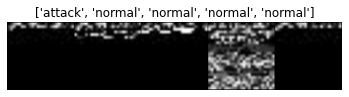

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_with_ip_linear_transformation, batch size: 128
ResNet34 model parameters: LR: 0.005, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 0.6948 acc: 0.5771
test loss: 0.7374 acc: 0.4870

Epoch 2/7
----------
train loss: 0.6906 acc: 0.5833
test loss: 0.6856 acc: 0.5584

Epoch 3/7
----------
train loss: 0.6549 acc: 0.6141
test loss: 0.6575 acc: 0.6077

Epoch 4/7
----------
train loss: 0.6538 acc: 0.6168
test loss: 0.6544 acc: 0.6121

Epoch 5/7
----------
train loss: 0.6504 acc: 0.6196
test loss: 0.6544 acc: 0.6120

Epoch 6/7
----------
train loss: 0.6504 acc: 0.6184
test loss: 0.6541 acc: 0.6124

Epoch 7/7
----------
train loss: 0.6499 acc: 0.6201
test loss: 0.6541 acc: 0.6120

Training complete in 52m 5s
Best val acc: 0.612400
Train ResNet34 model end
CPU times: user 49min 40s, sys: 2min 8s, total: 51min 48s
Wall time: 52min 5s


In [ ]:
for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_mobilenetv3_small(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels, predictions[:30000], log=logger)

NameError: ignored

# Linear transformation WITH IP FIRST 100 VALUES

## Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601277.561405_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601312.011126_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601336.157944_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601209.143585_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601261.915594_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601316.183671_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601322.365693_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation_test/attack/1575601308.850708_1.jpg
SWaT_Dec2019_ep_experimental_image_with_ip_f

## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation'
LEARNING_RATE = 0.01
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 32
VALIDATION = False

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 70000 images under train
Loaded 30000 images under test
Classes: ['attack', 'normal']


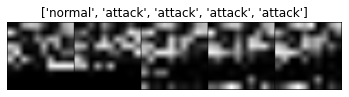

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation, batch size: 32
ResNet34 model parameters: LR: 0.01, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 1.0510 acc: 0.5695
test loss: 1.0612 acc: 0.4801

Epoch 2/7
----------
train loss: 1.0322 acc: 0.5747
test loss: 0.9686 acc: 0.5192

Epoch 3/7
----------
train loss: 0.6663 acc: 0.6317
test loss: 0.6338 acc: 0.6465

Epoch 4/7
----------
train loss: 0.6523 acc: 0.6317
test loss: 0.6337 acc: 0.6432

Epoch 5/7
----------
train loss: 0.6310 acc: 0.6454
test loss: 0.6344 acc: 0.6404

Epoch 6/7
----------
train loss: 0.6289 acc: 0.6500
test loss: 0.6292 acc: 0.6507

Epoch 7/7
----------
train loss: 0.6265 acc: 0.6490
test loss: 0.6275 acc: 0.6514

Training complete in 56m 12s
Best val acc: 0.651400
Train ResNet34 model end
CPU times: user 55min 13s, sys: 1min 8s, total: 56min 21s
Wall time: 56min 12s


In [ ]:
for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_resnet34(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels, predictions[:30000], log=logger)

# Different transformations NEAREST interpolation FIRST 121 VALUES

## Downloading data

In [22]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601591.558705.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601592.81819.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601600.91502.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601702.23041.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601642.126294.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601670.891342.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601702.404623.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601518.831266.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/n

## Define dataloaders and constants

In [23]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation'
LEARNING_RATE = 0.001
STEP_SIZE = 5
GAMMA = 0.1
EPOCHS_COUNT = 20
BATCH_SIZE = 128
VALIDATION = False
INTERPOLATION = transforms.InterpolationMode.NEAREST

dataloaders, dataset_sizes, class_names = define_dataloaders_custom(dataset_name=dataset_name, interpolation=INTERPOLATION, batch_size=BATCH_SIZE, val=VALIDATION, s=150)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 14000 images under train
Loaded 6000 images under test
Classes: ['attack', 'normal']


tensor([[[[0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000],
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000],
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000],
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000],
          [0.7882, 0.7882, 0.7882,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0196, 0.0196,  ..., 0

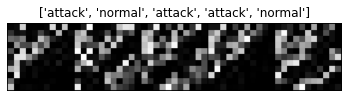

In [24]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
print(inputs)
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [40]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
sum(p.numel() for p in model_resnet34.parameters())

21797672

In [42]:
from torchvision.models import resnet50
from thop import profile
from thop import clever_format
model = resnet50()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model_resnet34, inputs=(input, ))
macs, params = clever_format([macs, params], "%.2f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.BasicBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.ResNet'>. Treat it as zero Macs and zero Params.
3.67G
21.80M


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


In [26]:
sum(p.numel() for p in model_resnet34.parameters() if p.requires_grad)

21797672

In [27]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

In [28]:
sum(p.numel() for p in model_resnet34.parameters())

21285698

In [29]:
sum(p.numel() for p in model_resnet34.parameters() if p.requires_grad)

1026

In [31]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.ResNet'>. Treat it as zero Macs and zero Params.
4111514624.0
25557032.0


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


In [39]:
from thop import clever_format
macs, params = clever_format([macs, params], "%.2f")
print(macs)
print(params)

4.11G
25.56M


In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('\n\n\nDevice: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('Interpolation: %s' % str(INTERPOLATION))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Interpolation: %s' % str(INTERPOLATION))  
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end' % model_resnet34.name)




Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_first121b_zigzag_transformation, batch size: 16
Interpolation: InterpolationMode.NEAREST
ResNet34 model parameters: LR: 0.001, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 0.7051 acc: 0.5735
test loss: 0.6866 acc: 0.6090

Epoch 2/7
----------
train loss: 0.7001 acc: 0.5800
test loss: 0.6953 acc: 0.5575

Epoch 3/7
----------
train loss: 0.6592 acc: 0.6110
test loss: 0.6612 acc: 0.6120

Epoch 4/7
----------
train loss: 0.6570 acc: 0.6133
test loss: 0.6606 acc: 0.6134

Epoch 5/7
----------
train loss: 0.6522 acc: 0.6165
test loss: 0.6565 acc: 0.6110

Epoch 6/7
----------
train loss: 0.6508 acc: 0.6208
test loss: 0.6546 acc: 0.6149

Epoch 7/7
----------
train loss: 0.6510 acc: 0.6205
test loss: 0.6553 acc: 0.6133

Training complete in 29m 19s
Best val acc: 0.614900
Train ResNet34 model end
CPU times: user 28min 43s, sys: 32.6 s, total: 29min 15s
Wall time: 29min 18s


Metrics values:
Test accuracy: 0.5636
Test balanced_accuracy 0.501
Test f1_score: 0.474
Classification report
              precision    recall  f1-score   support

           0       0.40      0.19      0.26     11992
           1       0.60      0.81      0.69     18008

    accuracy                           0.56     30000
   macro avg       0.50      0.50      0.47     30000
weighted avg       0.52      0.56      0.52     30000




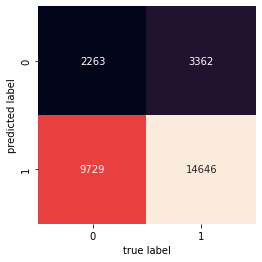

CPU times: user 1min 12s, sys: 1.31 s, total: 1min 13s
Wall time: 1min 13s


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 972, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [ ]:
%%time
predictions = list()
true_labels = list()

model_resnet34.eval()

for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_resnet34(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels, predictions[:30000], log=logger)

## MobileNet_v3_small

### One head layer

In [43]:
model_mobilenetv3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
sum(p.numel() for p in model_mobilenetv3_small.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

2542856

In [44]:
from torchvision.models import resnet50
from thop import profile
from thop import clever_format
model = resnet50()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model_mobilenetv3_small, inputs=(input, ))
macs, params = clever_format([macs, params], "%.2f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Hardswish'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.ops.misc.ConvNormActivation'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Hardsigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.ops.misc.SqueezeExcitation'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.mobilenetv3.InvertedResidual'>. Tr

/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


In [ ]:
model_mobilenetv3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
for param in model_mobilenetv3_small.parameters():
    param.requires_grad = False
num_features_mobilenetv3_small = model_mobilenetv3_small.classifier[-1].in_features
model_mobilenetv3_small.classifier[-1] = nn.Linear(num_features_mobilenetv3_small, len(class_names))
model_mobilenetv3_small.name = 'MobileNet_v3_small'
model_mobilenetv3_small = model_mobilenetv3_small.to(device)

criterion_mobilenetv3_small = nn.CrossEntropyLoss()
optimizer_mobilenetv3_small = optim.SGD(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
# optimizer_mobilenetv3_small = optim.Adam(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler_mobilenetv3_small= lr_scheduler.StepLR(optimizer_mobilenetv3_small, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
sum(p.numel() for p in model_mobilenetv3_small.parameters())

1519906

In [ ]:
sum(p.numel() for p in model_mobilenetv3_small.parameters() if p.requires_grad)

2050

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('Interpolation: %s' % str(INTERPOLATION))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_mobilenetv3_small.name)
if logger is not None:
  logger.info('\n\n\nDevice: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('Interpolation: %s' % str(INTERPOLATION))  
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_mobilenetv3_small.name)
model_mobilenetv3_small = train_model(model=model_mobilenetv3_small, 
                                                        criterion=criterion_mobilenetv3_small, 
                                                        optimizer=optimizer_mobilenetv3_small,
                                                        scheduler=exp_lr_scheduler_mobilenetv3_small, 
                                                        num_epochs=EPOCHS_COUNT, 
                                                        dataloaders=dataloaders, 
                                                        phase_names=phase_names,
                                                        device=device,
                                                        log=logger)
if model_mobilenetv3_small is not None: 
  print('Train %s model end' % model_mobilenetv3_small.name)
  if logger is not None: 
    logger.info('Train %s model end' % model_mobilenetv3_small.name)

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation, batch size: 8
Interpolation: InterpolationMode.BICUBIC
MobileNet_v3_small model parameters: LR: 0.001, SS: 5, G: 0.1, EC: 20
Train MobileNet_v3_small model start ...
Epoch 1/20
----------
train loss: 0.6800 acc: 0.5856
test loss: 0.6751 acc: 0.5985

Epoch 2/20
----------
train loss: 0.6714 acc: 0.5965
test loss: 0.6788 acc: 0.6088

Epoch 3/20
----------
train loss: 0.6677 acc: 0.6045
test loss: 0.6692 acc: 0.5965

Epoch 4/20
----------
train loss: 0.6697 acc: 0.5983
test loss: 0.6726 acc: 0.5885

Epoch 5/20
----------
train loss: 0.6710 acc: 0.6034
test loss: 0.6743 acc: 0.6043

Epoch 6/20
----------
train loss: 0.6565 acc: 0.6134
test loss: 0.6685 acc: 0.6023

Epoch 7/20
----------
train loss: 0.6547 acc: 0.6192
test loss: 0.6674 acc: 0.6017

Epoch 8/20
----------
train loss: 0.6544 acc: 0.6165
test loss: 0.6671 acc: 0.5992

Epoch 9/20
----------
train loss: 0.6537 acc: 0.6157
test loss: 0.6

Metrics values:
Test accuracy: 0.6248
Test balanced_accuracy 0.494
Test f1_score: 0.4634
Classification report
              precision    recall  f1-score   support

           0       0.31      0.12      0.17      1633
           1       0.67      0.87      0.76      3367

    accuracy                           0.62      5000
   macro avg       0.49      0.49      0.46      5000
weighted avg       0.55      0.62      0.57      5000




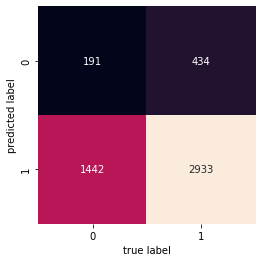

CPU times: user 8.27 s, sys: 284 ms, total: 8.55 s
Wall time: 8.51 s


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 972, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [ ]:
%%time
predictions = list()
true_labels = list()

model_mobilenetv3_small.eval()

for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_mobilenetv3_small(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels[:5000], predictions[:5000], log=logger)

## Custom CNN v.1

### Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# def precision(outputs, labels):
#   res = list()
#   _, preds = torch.max(outputs, dim=1)
#   for l in labels.unique():
#     res.append(torch.sum(preds[labels == l] == labels[labels == l]) / len(preds[labels == l]))
#   return res


# def recall(outputs, labels):
#   res = list()
#   _, preds = torch.max(outputs, dim=1)
#   for l in labels.unique():
#     res.append(torch.sum(preds[labels == l] == labels[labels == l]) / len(labels[labels == l]))
#   return res


def f1_func(outputs, labels):
  # precision = list()
  # recall = list()
  _, preds = torch.max(outputs, dim=1)
  f1 = list()
  for l in labels.unique():
    precision = (torch.sum(preds[labels == l] == labels[labels == l]) / len(preds[labels == l]))
    recall = (torch.sum(preds[labels == l] == labels[labels == l]) / len(labels[labels == l]))
    f1.append(2 * ((precision * recall) / (precision + recall)) * (torch.sum(labels == l).item() / len(labels)))
  return torch.tensor(torch.nanmean(torch.tensor(f1)).item())

  
def evaluate(model, val_loader):
  with torch.no_grad():
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  print('{} - Start fit ...'.format(datetime.now()))
  for epoch in range(epochs):  
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  print('{} - End fit'.format(datetime.now()))
  return history

In [ ]:
mtx = np.array([[20, 5], [15, 70]])
weights = [0.32, 0.68]
f1_l = list()
for i in range(2):
  precision = mtx[i, i] / sum(mtx[i, :])
  print('precision of %s: %s' % (i, precision))
  recall = mtx[i, i] / sum(mtx[:, i])
  print('recall of %s: %s' % (i, recall))
  f1 = 2 * ((precision * recall) / (precision + recall)) * weights[i]
  print('f1 of %s: %s' % (i, f1))
  f1_l.append(f1)
  print()
print('f1 weighted: %s' % np.mean(f1_l))

precision of 0: 0.8
recall of 0: 0.5714285714285714
f1 of 0: 0.21333333333333332

precision of 1: 0.8235294117647058
recall of 1: 0.9333333333333333
f1 of 1: 0.595

f1 weighted: 0.4041666666666667


In [ ]:
class ImageClassificationBase(nn.Module):
    
  def training_step(self, batch):
    images, labels = batch[0].to(device), batch[1].to(device)
    # print(labels.unique())
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  
  def validation_step(self, batch):
    images, labels = batch[0].to(device), batch[1].to(device)
    out = self(images)                    # Generate predictions

    # print(labels)
    # print(torch.max(out, dim=1))

    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    f1 = f1_func(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc, 'f1': f1}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    batch_f1s = [x['f1'] for x in outputs]
    # print(batch_f1s)
    epoch_f1s = torch.stack(batch_f1s).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_f1': epoch_f1s.item()}
  
  def epoch_end(self, epoch, result):
    print("{} - Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_f1: {:.4f}".format(
        datetime.now(), epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_f1']))

In [ ]:
class AttackClassificator(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

### Run

In [ ]:
model = AttackClassificator()

In [ ]:
model.to(device)

AttackClassificator(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, dataloaders['train'], dataloaders['test'], opt_func)

2022-05-27 08:36:40.902007 - Start fit ...
2022-05-27 08:37:53.703811 - Epoch [0], train_loss: 0.7334, val_loss: 1.0127, val_acc: 0.6007, val_f1: 0.6007
2022-05-27 08:38:55.939470 - Epoch [1], train_loss: 0.8486, val_loss: 0.6969, val_acc: 0.6009, val_f1: 0.6009
2022-05-27 08:39:57.895953 - Epoch [2], train_loss: 0.7235, val_loss: 0.7453, val_acc: 0.6007, val_f1: 0.6007
2022-05-27 08:40:59.987847 - Epoch [3], train_loss: 2.1826, val_loss: 0.6868, val_acc: 0.6006, val_f1: 0.6006
2022-05-27 08:42:02.241820 - Epoch [4], train_loss: 0.7498, val_loss: 0.8418, val_acc: 0.6007, val_f1: 0.4415
2022-05-27 08:43:04.325215 - Epoch [5], train_loss: 1.0778, val_loss: 0.7042, val_acc: 0.6005, val_f1: 0.6005
2022-05-27 08:44:06.426612 - Epoch [6], train_loss: 27.4831, val_loss: 0.6730, val_acc: 0.6005, val_f1: 0.6005
2022-05-27 08:45:08.577261 - Epoch [7], train_loss: 0.7249, val_loss: 0.7465, val_acc: 0.6006, val_f1: 0.6006
2022-05-27 08:46:10.668686 - Epoch [8], train_loss: 7.2698, val_loss: 0.6746

## Custom CNN v.2

### Definition

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 128 x 128, Output = 32 x 128 x 128
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            #Input = 32 x 128 x 128, Output = 32 x 64 x 64
            torch.nn.MaxPool2d(kernel_size=2),
  
            #Input = 32 x 64 x 64, Output = 64 x 64 x 64
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 64 x 64, Output = 64 x 32 x 32
            torch.nn.MaxPool2d(kernel_size=2),
              
            #Input = 64 x 32 x 32, Output = 64 x 32 x 32
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 32 x 32, Output = 64 x 16 x 16
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(64*16*16, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 2)
        )
  
    def forward(self, x):
        return self.model(x)

### Run

Epoch 1/20: Training loss = 0.6795764381235296
Epoch 2/20: Training loss = 0.6740436180071397
Epoch 3/20: Training loss = 0.6740356380289251
Epoch 4/20: Training loss = 0.6742042427713221
Epoch 5/20: Training loss = 0.6740298975597728
Epoch 6/20: Training loss = 0.6739881775595925
Epoch 7/20: Training loss = 0.673686237226833
Epoch 8/20: Training loss = 0.6737565354867415
Epoch 9/20: Training loss = 0.6738391757011414
Epoch 10/20: Training loss = 0.6736043003472415
Epoch 11/20: Training loss = 0.6734694524244829
Epoch 12/20: Training loss = 0.67327742414041
Epoch 13/20: Training loss = 0.6730850046331233
Epoch 14/20: Training loss = 0.6732711878689852
Epoch 15/20: Training loss = 0.6735638309608806
Epoch 16/20: Training loss = 0.6731581005183134
Epoch 17/20: Training loss = 0.6731828261505474
Epoch 18/20: Training loss = 0.6732077018781142
Epoch 19/20: Training loss = 0.6732826270840385
Epoch 20/20: Training loss = 0.6732244540344585


Text(0, 0.5, 'Training loss')

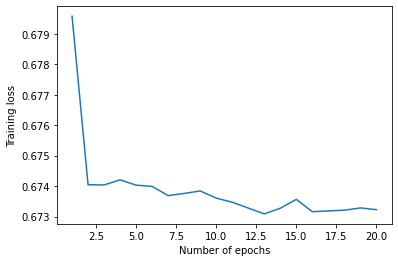

In [ ]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
train_loader = dataloaders['train']
  
#Defining the model hyper parameters
num_epochs = 20
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  
#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    train_loss = 0
      
    #Iterating over the training dataset in batches
    model.train()
    for i, (images, labels) in enumerate(train_loader):
          
        #Extracting images and target labels for the batch being iterated
        images = images.to(device)
        labels = labels.to(device)
  
        #Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = criterion(outputs, labels)
  
        #Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
      
    #Printing loss for each epoch
    train_loss_list.append(train_loss/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")   
      
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [ ]:
test_loader = dataloaders['test']
test_acc=0
model.eval()
  
with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(test_loader):
          
        images = images.to(device)
        y_true = labels.to(device)
          
        #Calculating outputs for the batch being iterated
        outputs = model(images)
          
        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)
          
        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()
      
    print(f"Test set accuracy = {100 * test_acc / dataset_sizes['test']}%")

Test set accuracy = 60.06666666666667%


## VGG16

### One head layer

In [ ]:
model_vgg16 = torchvision.models.vgg16(pretrained=True)
sum(p.numel() for p in model_vgg16.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

138357544

In [ ]:
model_vgg16= torchvision.models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
# num_features_vgg1 = model_vgg16.classifier[-1].in_features
# model_vgg16.classifier[-1] = nn.Linear(num_features_vgg1, len(class_names))

num_features_vgg16 = model_vgg16.classifier[-1].in_features
model_vgg16.classifier[-1] = nn.Linear(num_features_vgg16, len(class_names))
model_vgg16.name = 'VGG16'
model_vgg16 = model_vgg16.to(device)

criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.SGD(model_vgg16.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
# optimizer_mobilenetv3_small = optim.Adam(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler_vgg16= lr_scheduler.StepLR(optimizer_vgg16, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
sum(p.numel() for p in model_vgg16.parameters())

134268738

In [ ]:
sum(p.numel() for p in model_vgg16.parameters() if p.requires_grad)

8194

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('Interpolation: %s' % str(INTERPOLATION))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_vgg16.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_vgg16.name)
if logger is not None:
  logger.info('\n\n\nDevice: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('Interpolation: %s' % str(INTERPOLATION))  
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_vgg16.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_vgg16.name)
model_vgg16 = train_model(model=model_vgg16, 
                                                        criterion=criterion_vgg16, 
                                                        optimizer=optimizer_vgg16,
                                                        scheduler=exp_lr_scheduler_vgg16, 
                                                        num_epochs=EPOCHS_COUNT, 
                                                        dataloaders=dataloaders, 
                                                        phase_names=phase_names,
                                                        device=device,
                                                        log=logger)
if model_vgg16 is not None: 
  print('Train %s model end' % model_vgg16.name)
  if logger is not None: 
    logger.info('Train %s model end' % model_vgg16.name)

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation, batch size: 8
Interpolation: InterpolationMode.NEAREST
VGG16 model parameters: LR: 0.001, SS: 5, G: 0.1, EC: 20
Train VGG16 model start ...
Epoch 1/20
----------
train loss: 0.8174 acc: 0.5355
test loss: 0.6884 acc: 0.6015

Epoch 2/20
----------
Function interrupted
CPU times: user 6min 31s, sys: 2.23 s, total: 6min 33s
Wall time: 6min 34s


Metrics values:
Test accuracy: 0.6248
Test balanced_accuracy 0.494
Test f1_score: 0.4634
Classification report
              precision    recall  f1-score   support

           0       0.31      0.12      0.17      1633
           1       0.67      0.87      0.76      3367

    accuracy                           0.62      5000
   macro avg       0.49      0.49      0.46      5000
weighted avg       0.55      0.62      0.57      5000




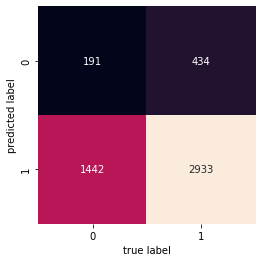

CPU times: user 8.27 s, sys: 284 ms, total: 8.55 s
Wall time: 8.51 s


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 972, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [ ]:
%%time
predictions = list()
true_labels = list()

model_vgg16.eval()

for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_vgg16(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels[:5000], predictions[:5000], log=logger)

# Linear transformation BICUBIC interpolation WITH IP FIRST 100 VALUES 

## Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601541.511959.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601618.455729.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601600.719388.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601579.868331.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601549.755401.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601568.971386.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601586.719012.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601532.672925.jpg
SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation_test/normal/1575601525.995751.jpg
SWaT_Dec2019_ep_experim

## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_first121b_spiral_transformation'
LEARNING_RATE = 0.001
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 16
VALIDATION = False
INTERPOLATION = transforms.InterpolationMode.BICUBIC

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, interpolation=INTERPOLATION, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 70000 images under train
Loaded 30000 images under test
Classes: ['attack', 'normal']


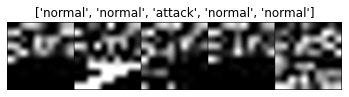

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## MobileNet_v3_small ADAM optimizer without scheduler

### One head layer

In [ ]:
model_mobilenetv3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
sum(p.numel() for p in model_mobilenetv3_small.parameters())

2542856

In [ ]:
model_mobilenetv3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
for param in model_mobilenetv3_small.parameters():
    param.requires_grad = False
num_features_mobilenetv3_small = model_mobilenetv3_small.classifier[-1].in_features
model_mobilenetv3_small.classifier[-1] = nn.Linear(num_features_mobilenetv3_small, len(class_names))
model_mobilenetv3_small.name = 'MobileNet_v3_small'
model_mobilenetv3_small = model_mobilenetv3_small.to(device)

criterion_mobilenetv3_small = nn.CrossEntropyLoss()
# optimizer_mobilenetv3_small = optim.SGD(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer_mobilenetv3_small = optim.Adam(model_mobilenetv3_small.classifier.parameters(), lr=LEARNING_RATE)
# exp_lr_scheduler_mobilenetv3_small= lr_scheduler.StepLR(optimizer_mobilenetv3_small, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
sum(p.numel() for p in model_mobilenetv3_small.parameters())

1519906

In [ ]:
sum(p.numel() for p in model_mobilenetv3_small.parameters() if p.requires_grad)

2050

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('Interpolation: %s' % str(INTERPOLATION))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_mobilenetv3_small.name)
if logger is not None:
  logger.info('\n\n\nDevice: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('Interpolation: %s' % str(INTERPOLATION))  
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_mobilenetv3_small.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_mobilenetv3_small.name)
model_mobilenetv3_small = train_model_without_scheduler(model=model_mobilenetv3_small, 
                                                        criterion=criterion_mobilenetv3_small, 
                                                        optimizer=optimizer_mobilenetv3_small,
                                                        # scheduler=exp_lr_scheduler_mobilenetv3_small, 
                                                        num_epochs=EPOCHS_COUNT, 
                                                        dataloaders=dataloaders, 
                                                        phase_names=phase_names,
                                                        device=device,
                                                        log=logger)
if model_mobilenetv3_small is not None: 
  print('Train %s model end' % model_mobilenetv3_small.name)
  if logger is not None: 
    logger.info('Train %s model end' % model_mobilenetv3_small.name)




Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_with_ip_first100b_linear_transformation, batch size: 8
Interpolation: InterpolationMode.BICUBIC
MobileNet_v3_small model parameters: LR: 0.005, SS: 2, G: 0.1, EC: 7
Train MobileNet_v3_small model start ...
Epoch 1/7
----------
train loss: 0.8065 acc: 0.5752
test loss: 0.7417 acc: 0.5834

Epoch 2/7
----------
train loss: 0.8109 acc: 0.5718
test loss: 0.7697 acc: 0.5536

Epoch 3/7
----------
train loss: 0.8125 acc: 0.5751
test loss: 0.7204 acc: 0.5988

Epoch 4/7
----------
train loss: 0.8090 acc: 0.5777
test loss: 0.7835 acc: 0.6095

Epoch 5/7
----------
train loss: 0.8077 acc: 0.5774
test loss: 0.7169 acc: 0.6059

Epoch 6/7
----------
train loss: 0.8132 acc: 0.5738
test loss: 0.7563 acc: 0.5792

Epoch 7/7
----------
train loss: 0.8107 acc: 0.5742
test loss: 0.7569 acc: 0.5913

Training complete in 35m 58s
Best val acc: 0.609500
Train MobileNet_v3_small model end
CPU times: user 35min 6s, sys: 54.5 s, total: 36min 1s
Wall time: 3

Metrics values:
Test accuracy: 0.6013
Test balanced_accuracy 0.5
Test f1_score: 0.3755
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11962
           1       0.60      1.00      0.75     18038

    accuracy                           0.60     30000
   macro avg       0.30      0.50      0.38     30000
weighted avg       0.36      0.60      0.45     30000




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


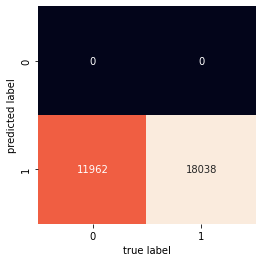

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

CPU times: user 1min 26s, sys: 1.82 s, total: 1min 28s
Wall time: 1min 28s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
predictions = list()
true_labels = list()

model_mobilenetv3_small.eval()

for batch_idx, (data, target) in enumerate(dataloaders['test']):
  _, preds = torch.max(model_mobilenetv3_small(inputs.to('cuda:0')), 1)
  true_labels += target.tolist()
  predictions += preds.tolist()

show_report(true_labels, predictions[:30000], log=logger)

# Zig-zag transformation

## Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601229.518597_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601258.725956_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601238.671373_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601250.862765_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601248.679486_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601272.323756_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601215.719555_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601217.540494_1.jpg
SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct_test/attack/1575601234.671792_1.jpg
SWaT_

## Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct'
LEARNING_RATE = 0.005
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 32
VALIDATION = False

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 70000 images under train
Loaded 30000 images under test
Classes: ['attack', 'normal']


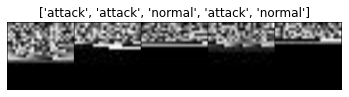

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

## ResNet34

### One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

Device: cuda:0
Data: SWaT_Dec2019_ep_experimental_image_zigzag_transformation_with_idct, batch size: 32
ResNet34 model parameters: LR: 0.005, SS: 2, G: 0.1, EC: 7
Train ResNet34 model start ...
Epoch 1/7
----------
train loss: 0.8323 acc: 0.5411
test loss: 1.2619 acc: 0.6016

Epoch 2/7
----------
train loss: 0.8515 acc: 0.5472
test loss: 0.7410 acc: 0.5963

Epoch 3/7
----------
train loss: 0.6788 acc: 0.5883
test loss: 0.6793 acc: 0.6019

Epoch 4/7
----------
train loss: 0.6751 acc: 0.5911
test loss: 0.6807 acc: 0.6015

Epoch 5/7
----------
train loss: 0.6634 acc: 0.6029
test loss: 0.6683 acc: 0.5986

Epoch 6/7
----------
train loss: 0.6625 acc: 0.6033
test loss: 0.6677 acc: 0.6004

Epoch 7/7
----------
train loss: 0.6607 acc: 0.6065
test loss: 0.6680 acc: 0.5954

Training complete in 45m 41s
Best val acc: 0.601867
Train ResNet34 model end
CPU times: user 42min 5s, sys: 2min 25s, total: 44min 31s
Wall time: 45min 41s


### Multiple head layers

In [ ]:
model_resnet34_head = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34_head.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34_head.fc.in_features
head_model = nn.Sequential(
	nn.Linear(num_features_resnet34, 512),
	nn.ReLU(),
	nn.Dropout(0.1),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Dropout(0.05),
	nn.Linear(256, len(class_names))
)
model_resnet34_head.fc = head_model
model_resnet34_head.name = 'ResNet34withHead'
model_resnet34_head = model_resnet34_head.to(device)

criterion_resnet34_head = nn.CrossEntropyLoss()
optimizer_resnet34_head = optim.SGD(model_resnet34_head.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34_head = lr_scheduler.StepLR(optimizer_resnet34_head, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34_head.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34_head.name)
model_resnet34_head = train_model(model=model_resnet34_head, 
                                  criterion=criterion_resnet34_head, 
                                  optimizer=optimizer_resnet34_head,
                                  scheduler=exp_lr_scheduler_resnet34_head, 
                                  num_epochs=EPOCHS_COUNT, 
                                  dataloaders=dataloaders, 
                                  phase_names=phase_names,
                                  device=device,
                                  log=logger)
if model_resnet34_head is not None: 
  print('Train %s model end' % model_resnet34_head.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34_head.name)

## MobileNet_v3_small